In [46]:
import torch
import torch.nn as nn
import torch.onnx
import tensorflow as tf
import onnx
from onnx_tf.backend import prepare
import numpy as np
import matplotlib.pyplot as plt

In [47]:
# Generate data
x = np.linspace(-2 * np.pi, 2 * np.pi, 1000)
y = np.sin(x)

# Convert to tensors
x_train = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y_train = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Define the model
model = nn.Sequential(
    nn.Linear(1, 50),
    nn.ReLU(),
    nn.Linear(50, 1)
)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [48]:
# Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    output = model(x_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

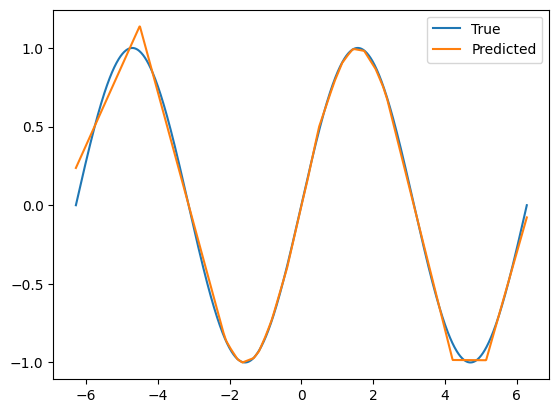

In [49]:
# Predict
with torch.no_grad():
    y_pred = model(x_train).numpy()

# Plot
plt.plot(x, y, label='True')
plt.plot(x, y_pred, label='Predicted')
plt.legend()
plt.show()

## Convert model to ONNX

In [50]:
def convert_torch_to_onnx(model, onnx_model_path = 'model.onnx'):
    data_size = (1, 1)
    batch_size = 1
    sample_input = torch.rand((batch_size, 3, *data_size))
    torch.onnx.export(
        model,
        sample_input, 
        onnx_model_path,
        verbose=False,
        input_names=['input'],
        output_names=['output'],
        opset_version=12
    )

convert_torch_to_onnx(model)

## Convert model to tensorflow

In [51]:
def convert_onnx_to_tensorflow(onnx_model_path = 'model.onnx', tf_model_path = 'model_tf'):
    onnx_model = onnx.load(onnx_model_path)
    tf_rep = prepare(onnx_model)
    tf_rep.export_graph(tf_model_path)

convert_onnx_to_tensorflow()

INFO:tensorflow:Assets written to: model_tf\assets


INFO:tensorflow:Assets written to: model_tf\assets


## Convert model to tensorflow lite

In [52]:
def convert_tensorflow_to_tensorflow_lite(tf_model_path = 'model_tf', tflite_model_path = 'model.tflite'):
    converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)
    tflite_model = converter.convert()

    # Save the model
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)

convert_tensorflow_to_tensorflow_lite()

## Convert tensorflow lite to c++ file

In [54]:
def save_tflite_model_as_c_header(tflite_model_path = 'model.tflite'):
    with open(tflite_model_path, "rb") as f:
        tflite_model_content = f.read()

    header_content = "alignas(16) const unsigned char g_model[] = {"
    for i, byte in enumerate(tflite_model_content):
        if i % 12 == 0:
            header_content += "\n  "
        header_content += f"0x{byte:02x}, "
    header_content = header_content.rstrip(", ")
    header_content += "\n};"

    with open("model.h", "w") as f:
        f.write(header_content)

save_tflite_model_as_c_header()